In [12]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import data.DataGenerator as dg

plt.style.use('figstyle.mplstyle')

# Let's initialize a 2D dynamical system governed by an Anosov diffeomorphism using DataGenerator.
n = 2              # System dimensionality
X0 = [0.1, 0.3]    # Arbitrary initial conditions with coordinates \in [0,1)
NUM_STEPS = 1001   # Number of iterations to evolve system state

generator = dg.DataGenerator(X0, num_steps = NUM_STEPS, mapname = "anosov_diffeo", map_args = None) # Take default transition matrix A
X = generator.generate_series() # Generate time series data; (NUM_STEPS, 2) array

Xk = X[:-1] # State data at timestep k
Xkplus1 = X[1:] # Evolved state data at timestep k+1 ( == F(Xk) )

Text(0.5, 1.0, '2D trajectory of Anosov map')

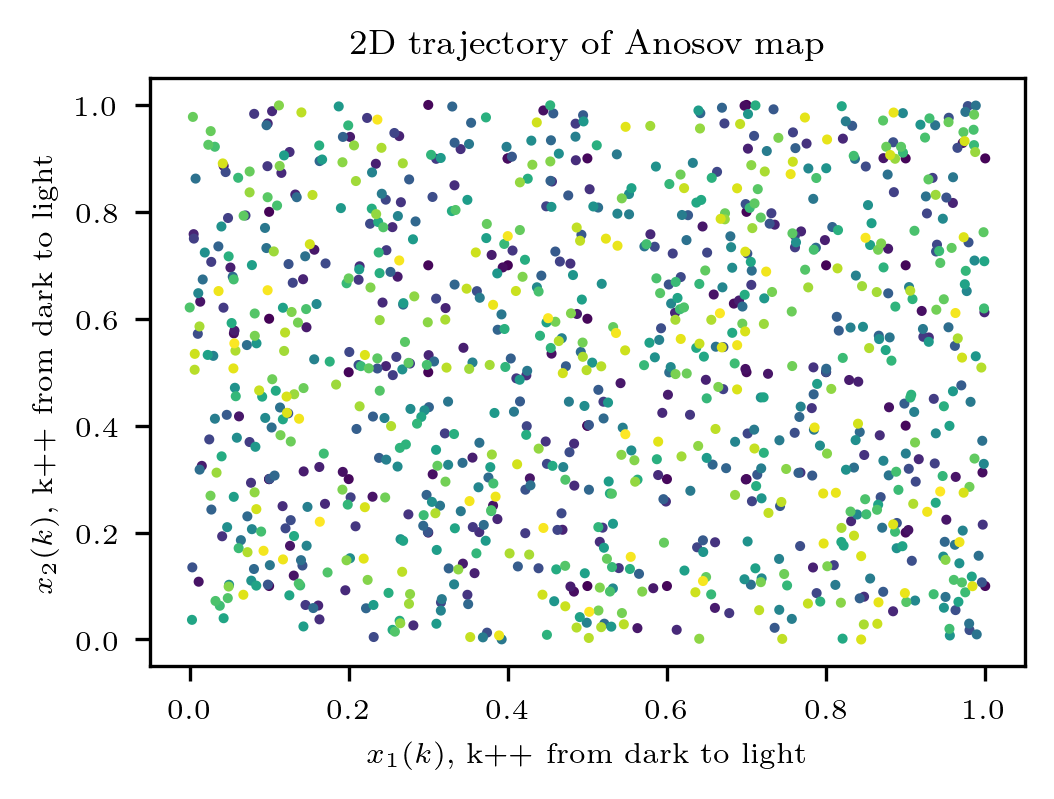

In [13]:
# Let's visualize this trajectory for the sake of example

cm = plt.get_cmap('viridis')
colors = [cm(i/NUM_STEPS) for i in range(NUM_STEPS)]

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=2, c=colors)
ax.set(xlabel=r'$x_1(k)$, k++ from dark to light', ylabel=r'$x_2(k)$, k++ from dark to light')
ax.set_title("2D trajectory of Anosov map")

In [40]:
# Set up dictionary of basis functions
# For now, we will use Hermite polynomials up to order max_deg = 3

from numpy.polynomial.hermite import Hermite

# Number of dictionary entries
def getDimPsi(n, max_deg):
    dim_Psi = 1
    for i in range(1, max_deg):
        dim_Psi += math.factorial(n + i - 1) / (math.factorial(i) * math.factorial(n - 1))

    return int(dim_Psi)

# Create library of monomial basis functions up to order max_deg = 3
def createBasis(n, max_deg):
    basis_fns = {'1': lambda x, y: 1}
    for i in range(0, max_deg + 1):
        for j in range(0, max_deg + 1 - i):
            basis_fns['x' * i + 'y' * j] = lambda x, y: x**i * y**j
    return basis_fns

# Create hermite basis of given degree and 1-dimensional inputs
# Use physicist's hermite polynomials here, not probabilist's (numpy.polynomial.hermite_e)
def HermiteBasis(n, max_deg, symbol = 'x'):
    basis = [Hermite.basis(i) for i in range(max_deg)]
    return basis

# By composing two 1D Hermite spaces of order max_deg, we create
# the 2D hermite basis of given degree as a (max_deg, max_deg) grid. indices along grid axes
# specify the order of the Hermite polynomial for that variable (x1 or x2, respectively).
# In the default case, take the order of the Hermite space for x2 to be equivalent to that of x1.
def HermiteBasis2D(n, m = n, max_deg = 3, sym = ['x', 'y']):
    Hx1 = HermiteBasis(n, max_deg, symbol = sym[0])
    Hx2 = HermiteBasis(m, max_deg, symbol = 'y')

    basis2D = [[Hx1[i]*Hx2[j] for i in range(max_deg)] for j in range(max_deg)]
    return basis2D

In [50]:
print([f'{i}\n' for i in createBasis(n, max_deg=3).values()])

['<function createBasis.<locals>.<lambda> at 0x1436a3ba0>\n', '<function createBasis.<locals>.<lambda> at 0x1436a3ce0>\n', '<function createBasis.<locals>.<lambda> at 0x1436a3b00>\n', '<function createBasis.<locals>.<lambda> at 0x1436a3c40>\n', '<function createBasis.<locals>.<lambda> at 0x1436e85e0>\n', '<function createBasis.<locals>.<lambda> at 0x1436e8540>\n', '<function createBasis.<locals>.<lambda> at 0x1436e8360>\n', '<function createBasis.<locals>.<lambda> at 0x1436e82c0>\n', '<function createBasis.<locals>.<lambda> at 0x1436e8220>\n', '<function createBasis.<locals>.<lambda> at 0x1436e80e0>\n', '<function createBasis.<locals>.<lambda> at 0x1436e8040>\n']
